In [1]:
# read all image files from a directory. later on batching needs to be supported
# chropping the images to remove unnecessary part of the images 
# also capture label information from meatadata file
# visualize the images at each stage
# transform from 3 channels to one channel 
# slice the images into train and validation data sets
# combine array of images and label into tuples - array of tuple(three dimension array of image and label array) - [[30,16,1], .09]
# store these array into pickle files - train.p and test.p 

In [2]:
# read all image files from a directory. later on batching needs to be supported
# from data directory 
import csv
import cv2
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.misc
%matplotlib inline
matplotlib.style.use('ggplot')

img_dir = "data/"
label_dir = "{}/driving_log.csv".format(img_dir)
input_shape = (27, 107, 3) #(18, 80, 3)

# import img_label
data = []

with open(label_dir) as file:
    reader = csv.reader(file)
    for i in reader:
        data.append(i)

print("imported data")
data_size = len(data)
print("size of import data", data_size)
print("visualize import data: ", data[random.randrange(data_size)])

random.shuffle(data)
train_data = data[:int(data_size*.8)]
validate_data = data[int(data_size*.8):int(data_size*.9)]
test_data = data[int(data_size*.9):]

print("train size:", len(train_data))
print("valid size:", len(validate_data))
print("test size:", len(test_data))

imported data
size of import data 8036
visualize import data:  ['IMG/center_2016_12_01_13_41_22_375.jpg', ' IMG/left_2016_12_01_13_41_22_375.jpg', ' IMG/right_2016_12_01_13_41_22_375.jpg', ' 0', ' 0.9855326', ' 0', ' 30.18611']
train size: 6428
valid size: 804
test size: 804


100%|██████████| 8036/8036 [00:00<00:00, 615849.20items/s]


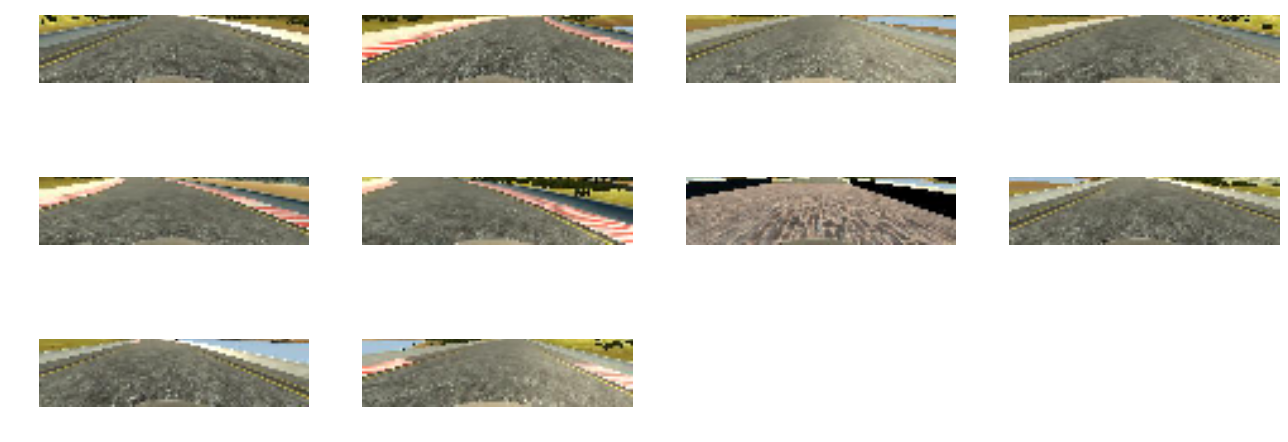

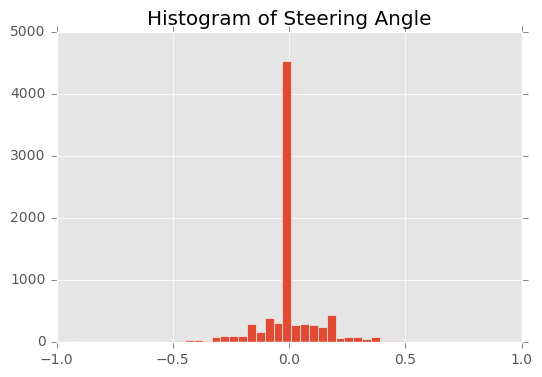

(27, 107, 3)


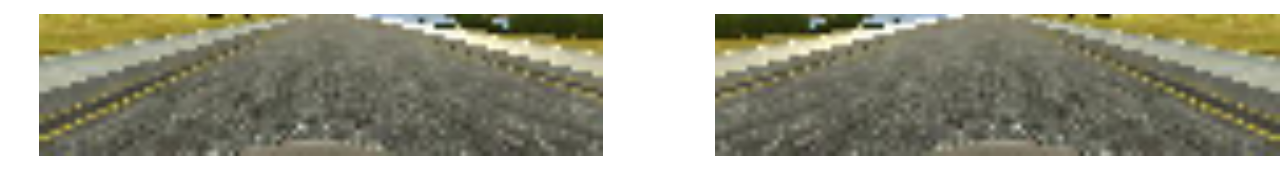

In [3]:
from scipy.stats import bernoulli

#img_label = img_label[:4000]
# take all three images, crop it to get only area of image that are relevent for training. We don't need tree 
# and other unnecessary information from image
# next flatten it and convert into list
def load_image(line, j):
    img = plt.imread("data/" +(line[j]).strip())
    img =  crop(img)
    return img 
    #random_gamma(img)

def load_normalize_image(line, j):
    image = load_image(line,j)
    image_list = image.flatten().tolist()
    image_array = np.reshape(np.array(image_list), newshape=input_shape)
    image_array = image_array / 255 - 0.5
    return image_array
    
def crop(image):
    return image[65:145:3,0:-1:3,:]

def random_flip(image, steering_angle):
    
    head = random.choice(range(0,1))
    if head:
        return np.fliplr(image), -1 * steering_angle
    else:
        return image, steering_angle


def random_gamma(image):
    """
    Random gamma correction is used as an alternative method changing the brightness of
    training images.
    http://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
    :param image:
        Source image
    :return:
        New image generated by applying gamma correction to the source image
    """
    gamma = np.random.uniform(0.4, 1.5)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def pltTrainingData(data):
    plt.figure(figsize=(16,8))
    for c in range(10):
        index = random.randint(0,len(data))
        plt.subplot(4, 4, c+1)
        plt.axis('off')
        img = np.array(load_image(data[index], 0))
        img = np.squeeze(img)
        plt.imshow(img)
def pltSteeringAnglrHistrogram(steering_angle):
    plt.figure()
    plt.hist(steering_angle, bins=51)  
    plt.title("Histogram of Steering Angle")
    plt.show()
def pltflipped(data):
    plt.figure(figsize=(16,8))
    plt.title("Flipped Images")
    plt.subplot(2, 2, 1)
    plt.axis('off')
    img = np.array(load_image(data[0], 0))
    img = np.squeeze(img)
    print(img.shape)
    plt.imshow(img)
    img = np.fliplr(img)
    plt.subplot(2, 2, 2)
    plt.axis('off')
    plt.imshow(img)
steering_angle = []
### extract the label and save them in labels numpy array
for i in tqdm(range(int(data_size)), unit='items'):
        steering_angle += (float(data[i][3]),)

assert len(steering_angle) == len(data), 'len(steering_angle) == len(data) should be Same'

pltTrainingData(data)
pltSteeringAnglrHistrogram(steering_angle)
pltflipped(data)

(3, 27, 107, 3)
(3,)


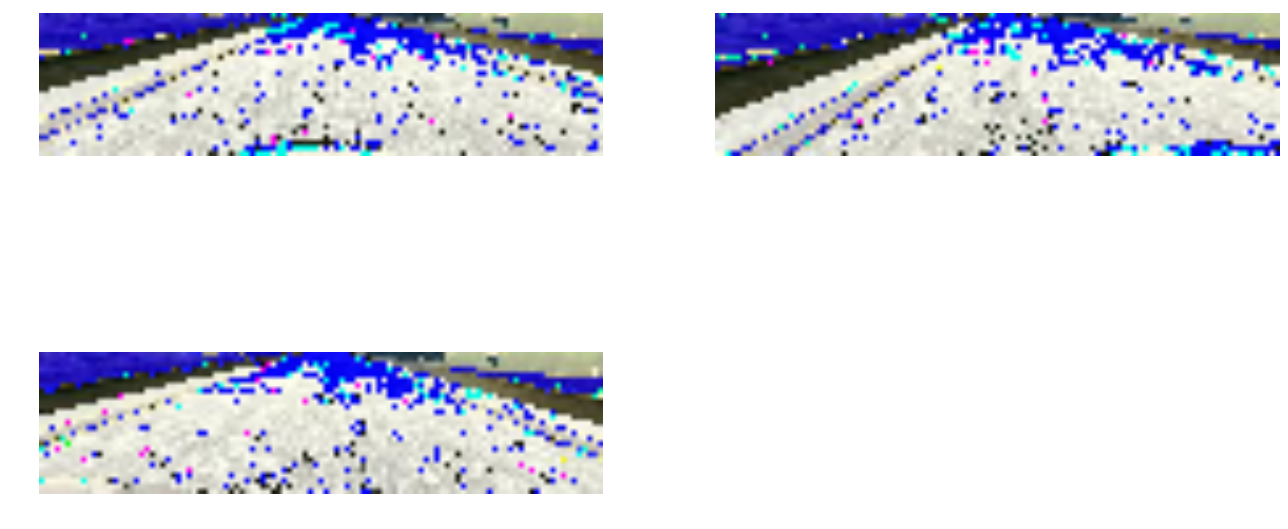

In [4]:
STEERING_COEFFICIENT = 0.2

def get_images(drivingLogRow):
    X_train = []
    y_train = []
    ### load all images
    for j in range(3):
        image = np.array(load_normalize_image(drivingLogRow,j),)
        #center camera image
        if j == 0:
            steering_angle = float(drivingLogRow[3])
        #left camera image
        elif j == 1:
            steering_angle = float(drivingLogRow[3]) + STEERING_COEFFICIENT
        #right camera image
        elif j == 2:
            steering_angle = float(drivingLogRow[3]) - STEERING_COEFFICIENT
        
        image, steering_angle = random_flip(image, steering_angle)

        #image = random_gamma(image)  
    
        X_train.append(image.tolist())
        y_train.append(steering_angle)
    assert len(X_train) == len(y_train), 'len(X_train) == len(y_train) should be same' 
    return np.array(X_train), np.array(y_train)

X_train, y_train = get_images(data[0])
print(X_train.shape)
print(y_train.shape)
plt.figure(figsize=(16,8))
for c in range(3):
    plt.subplot(2, 2, c+1)
    plt.axis('off')
    plt.imshow(X_train[c])

In [5]:
import json
import os
import h5py

def save_model(model):
    # Save the model.
    # If the model.json file already exists in the local file,
    # warn the user to make sure if user wants to overwrite the model.
    if 'model.json' in os.listdir():
        os.remove('model.json')
    if 'model.h5' in os.listdir():
        os.remove('model.h5')    
    else:
        # Save model as json file
        json_string = model.to_json()

        with open('model.json', 'w') as outfile:
            json.dump(json_string, outfile)

            # save weights
            model.save_weights('./model.h5')
            print("Saved")           

In [6]:
#generator 
import itertools
NO_IMAGES = 3
def generator(drivingLogRows, batch_size=64):
    infiniteDrivingLogRows = itertools.cycle(drivingLogRows)
    counter = 0
    X = []
    y = []    
    while True:
        if (counter >= batch_size):
            counter = 0
            X_x = np.array(X).reshape(NO_IMAGES*len(X), 27, 107, 3) #18,80, 3)
            y_y = np.array(y).reshape(NO_IMAGES*len(y))
            X = []
            y = []
            yield X_x, y_y
        drivingLogRow = next(infiniteDrivingLogRows)
        features, labels = get_images(np.squeeze(drivingLogRow))
        X.append(features.tolist())
        y.append(labels.tolist())
        counter = counter + NO_IMAGES  
        

In [7]:
# import tensorflow as tf
# from keras.layers import Dense, Flatten, Lambda, Activation, MaxPooling2D, Dropout
# from keras.layers.convolutional import Convolution2D
# from keras.models import Sequential
# from keras.optimizers import Adam

# tf.python.control_flow_ops = tf

# number_of_epochs = 8
# number_of_samples_per_epoch = len(train_data)
# number_of_validation_samples = len(validate_data)
# number_of_test_samples = len(test_data)
# learning_rate = 1e-4
# activation_relu = 'relu'

# # Our model is based on NVIDIA's "End to End Learning for Self-Driving Cars" paper
# # Source:  https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

# model = Sequential()

# model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(64, 64, 3)))

# # starts with five convolutional and maxpooling layers
# model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2, 2)))
# model.add(Activation(activation_relu))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

# model.add(Convolution2D(8, 5, 5, border_mode='same', subsample=(2, 2)))
# model.add(Activation(activation_relu))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

# model.add(Convolution2D(8, 5, 5, border_mode='same', subsample=(2, 2)))
# model.add(Activation(activation_relu))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

# model.add(Convolution2D(4, 3, 3, border_mode='same', subsample=(1, 1)))
# model.add(Activation(activation_relu))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

# model.add(Convolution2D(4, 3, 3, border_mode='same', subsample=(1, 1)))
# model.add(Activation(activation_relu))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
# model.add(Dropout(0.5))
# model.add(Flatten())

# # Next, five fully connected layers
# # model.add(Dense(100))
# # model.add(Activation(activation_relu))

# # model.add(Dense(100))
# # model.add(Activation(activation_relu))

# model.add(Dense(50))
# model.add(Activation(activation_relu))

# model.add(Dense(10))
# model.add(Activation(activation_relu))

# model.add(Dense(1))

# model.summary()

# model.compile(optimizer=Adam(learning_rate), loss="mse", metrics=['accuracy'] )

# # create two generators for training and validation
# train_gen = generator(train_data, batch_size=1024)
# validation_gen = generator(validate_data, batch_size=1024)
# test_gen = generator(test_data, batch_size=1024)

# history = model.fit_generator(train_gen,
#                               samples_per_epoch=number_of_samples_per_epoch,
#                               nb_epoch=number_of_epochs,
#                               validation_data=validation_gen,
#                               nb_val_samples=number_of_validation_samples,
#                               verbose=1)

# # finally save our model and weights
# save_model(model)
# score = model.evaluate_generator(test_gen, val_samples=number_of_test_samples, verbose=1)
# print('Test score:', score)

In [8]:
from keras.layers import Conv2D, Flatten
from keras.layers.core import Dropout
from keras.layers.pooling import MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Input, Activation
from keras.optimizers import SGD, Adam, RMSprop
N_CLASSES = 1 # The output is a single digit: a steering angle

BATCH_SIZE = 64 # The lower the better
EPOCHS = 10 # The higher the better
LEARNING_RATE = 0.0015


no_samples_per_epoch = len(train_data)*3
validation_samples = len(validate_data)*3
test_samples = len(test_data)*3

# number of convolutional filters to use
nb_filters1 = 16
nb_filters2 = 8
nb_filters3 = 4
nb_filters4 = 2

# size of pooling area for max pooling
pool_size = (2, 2)

# convolution kernel size
kernel_size = (3, 3)

# Initiating the model
model = Sequential()

# Starting with the convolutional layer
# The first layer will turn 1 channel into 16 channels
model.add(Conv2D(nb_filters1, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))
# Applying ReLU
model.add(Activation('relu'))
# The second conv layer will convert 16 channels into 8 channels
model.add(Conv2D(nb_filters2, kernel_size[0], kernel_size[1]))
# Applying ReLU
model.add(Activation('relu'))
# The second conv layer will convert 8 channels into 4 channels
model.add(Conv2D(nb_filters3, kernel_size[0], kernel_size[1]))
# Applying ReLU
model.add(Activation('relu'))
# The second conv layer will convert 4 channels into 2 channels
model.add(Conv2D(nb_filters4, kernel_size[0], kernel_size[1]))
# Applying ReLU
model.add(Activation('relu'))
# Apply Max Pooling for each 2 x 2 pixels
model.add(MaxPooling2D(pool_size=pool_size))
# Apply dropout of 25%
model.add(Dropout(0.25))

# Flatten the matrix. The input has size of 360
model.add(Flatten())
# Input 360 Output 16
model.add(Dense(16))
# Applying ReLU
model.add(Activation('relu'))
# Input 16 Output 16
model.add(Dense(16))
# Applying ReLU
model.add(Activation('relu'))
# Input 16 Output 16
model.add(Dense(16))
# Applying ReLU
model.add(Activation('relu'))
# Apply dropout of 50%
model.add(Dropout(0.5))
# Input 16 Output 1
model.add(Dense(N_CLASSES))

model.summary()



model.compile(loss='mean_squared_error',
              optimizer=Adam(LEARNING_RATE),
              metrics=['accuracy'])


###################################
##
##  6. Create 3 generators
##  training, validation, testing
##
###################################


# create two generators for training and validation
train_gen = generator(train_data, batch_size=64)
validation_gen = generator(validate_data, batch_size=64)
test_gen = generator(test_data, batch_size=64)

###################################
##
##  7. Train Model
##
###################################
history = model.fit_generator(train_gen, 
                    nb_epoch=EPOCHS,
                    samples_per_epoch=no_samples_per_epoch,
                    nb_val_samples=validation_samples,
                    validation_data=validation_gen,
                    verbose=1)

save_model(model)
score = model.evaluate_generator(test_gen, test_samples)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 25, 105, 16)   448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 25, 105, 16)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 23, 103, 8)    1160        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 23, 103, 8)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________